## Importing packages

In [1]:
import os
import cv2
import timm
import torch
import logging
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from tqdm import tqdm
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split
from albumentations import Compose, Resize, Normalize
from torch.utils.data import DataLoader

2024-11-25 23:57:42.729089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 23:57:42.744803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 23:57:42.749596: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 23:57:42.761156: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Configurations

In [2]:
class Configurations:
    IMAGE_DIR = "/home/guest1/nachiketa/fmlproj/new/1/flickr30k_images/flickr30k_images" # Path of Images file
    CAPTIONS_FILE = "/home/guest1/nachiketa/fmlproj/new/1/flickr30k_images/results.csv" # Path of captions file
    MODEL_PATH = "/home/guest1/nachiketa/fmlproj/Final Files/best_model.pth"  # Path to the trained model
    BATCH_SIZE = 64
    WORKERS = 4
    IMG_LR = 1e-6
    TXT_LR = 1e-7
    PROJ_LR = 1e-5
    WEIGHT_DECAY = 1e-7
    EPOCHS = 20
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    IMG_MODEL_NAME = "vit_base_patch32_224"
    TXT_MODEL_NAME = "distilbert-base-uncased"
    IMG_SIZE = 224
    MAX_TOKEN_LEN = 200
    TEMP_FACTOR = 0.1
    PROJECTION_DIM = 256

## Model Components

In [3]:
class CLIPModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.image_encoder = timm.create_model(Configurations.IMG_MODEL_NAME, pretrained=True, num_classes=0)
        self.text_encoder = DistilBertModel.from_pretrained(Configurations.TXT_MODEL_NAME)
        self.image_projection = nn.Linear(768, Configurations.PROJECTION_DIM)
        self.text_projection = nn.Linear(768, Configurations.PROJECTION_DIM)

    def forward(self, images, input_ids, attention_mask):
        image_features = self.image_encoder(images)
        image_embeddings = F.normalize(self.image_projection(image_features), dim=1)

        text_features = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        text_embeddings = F.normalize(self.text_projection(text_features), dim=1)

        return image_embeddings, text_embeddings

## Dataset and DataLoader

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, captions, tokenizer, transforms):
        self.image_paths = image_paths.tolist()
        self.captions = captions.tolist()
        self.tokenizer = tokenizer
        self.transforms = transforms

    def __getitem__(self, idx):
        image_path = os.path.join(Configurations.IMAGE_DIR, self.image_paths[idx])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)["image"]

        tokenized_captions = self.tokenizer(
            self.captions[idx], padding="max_length", truncation=True,
            max_length=Configurations.MAX_TOKEN_LEN, return_tensors="pt"
        )
        return {
            "image": torch.tensor(image).permute(2, 0, 1).float(),
            "input_ids": tokenized_captions["input_ids"].squeeze(0),
            "attention_mask": tokenized_captions["attention_mask"].squeeze(0),
        }

    def __len__(self):
        return len(self.captions)

## Load Transforms

In [5]:
def get_transforms():
    return Compose([
        Resize(Configurations.IMG_SIZE, Configurations.IMG_SIZE, always_apply=True),
        Normalize(max_pixel_value=255.0, always_apply=True),
    ])

def get_data_transforms():
    return Compose([
        Resize(Configurations.IMG_SIZE, Configurations.IMG_SIZE, always_apply=True),
        Normalize(max_pixel_value=255.0, always_apply=True),
    ])

## DataLoader Preparation

In [6]:
def build_loaders(captions_df, tokenizer):
    transforms = get_transforms()

    class CustomDataset(torch.utils.data.Dataset):
        def __init__(self, image_paths, captions, tokenizer, transforms):
            self.image_paths = image_paths
            self.captions = captions
            self.tokenizer = tokenizer
            self.transforms = transforms

        def __len__(self):
            return len(self.captions)

        def __getitem__(self, idx):
            # Tokenize captions
            tokenized_caption = self.tokenizer(
                self.captions[idx], padding="max_length", truncation=True,
                max_length=Configurations.MAX_TOKEN_LEN, return_tensors="pt"
            )
            return {
                "input_ids": tokenized_caption["input_ids"].squeeze(0),
                "attention_mask": tokenized_caption["attention_mask"].squeeze(0),
            }

    dataset = CustomDataset(
        captions_df["image"].values, captions_df["caption"].values, tokenizer, transforms
    )
    return torch.utils.data.DataLoader(dataset, batch_size=Configurations.BATCH_SIZE, shuffle=False)

## Compute Caption Embeddings

In [7]:
def get_caption_embeddings(captions_df, model, tokenizer):
    """
    Compute embeddings for all captions in the dataset.
    """
    caption_loader = build_loaders(captions_df, tokenizer)
    model.eval()

    all_embeddings = []
    with torch.no_grad():
        for batch in tqdm(caption_loader, desc="Computing caption embeddings"):
            input_ids = batch["input_ids"].to(Configurations.DEVICE)
            attention_mask = batch["attention_mask"].to(Configurations.DEVICE)

            text_features = model.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
            text_embeddings = F.normalize(model.text_projection(text_features.last_hidden_state[:, 0, :]), dim=1)
            all_embeddings.append(text_embeddings)

    return torch.cat(all_embeddings, dim=0)

## Find Top Captions for a Query Image

In [8]:
def find_top_captions(model, query_image, caption_embeddings, captions, n=5):
    """
    Find the top N captions for a given query image.
    """
    model.eval()

    query_image = query_image.unsqueeze(0).to(Configurations.DEVICE)
    with torch.no_grad():
        image_features = model.image_encoder(query_image)
        image_embeddings = F.normalize(model.image_projection(image_features), dim=1)

        similarity_scores = (image_embeddings @ caption_embeddings.T).squeeze(0)
        probabilities = F.softmax(similarity_scores, dim=0)
        top_indices = torch.topk(probabilities, n).indices

    top_captions = [(captions[idx], probabilities[idx].item()) for idx in top_indices]
    return top_captions

## Loading Model

In [9]:
if __name__ == "__main__":
    tokenizer = DistilBertTokenizer.from_pretrained(Configurations.TXT_MODEL_NAME)
    model = CLIPModel()
    model.load_state_dict(torch.load(Configurations.MODEL_PATH))
    model.to(Configurations.DEVICE)

    train_df = pd.read_csv("train_captions.csv")
    valid_df = pd.read_csv("valid_captions.csv")
    all_captions_df = pd.concat([train_df, valid_df], ignore_index=True)

    caption_embeddings = get_caption_embeddings(all_captions_df, model, tokenizer)

/tmp/ipykernel_75263/3673800896.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(Configurations.MODEL_PATH))
Computing caption embeddings

## Image to Caption

In [10]:
query_image_path = "/home/guest1/nachiketa/fmlproj/Final Files/dance.jpg"  # duplicate this cell and change the path to get captions for new image
query_image = cv2.imread(query_image_path)
query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
query_image = get_transforms()(image=query_image)["image"]
query_image = torch.tensor(query_image).permute(2, 0, 1).float()

top_captions = find_top_captions(model, query_image, caption_embeddings, all_captions_df["caption"].values, n=5)

# Print results
print("Top captions for the query image:")
for i, (caption, prob) in enumerate(top_captions, 1):
    print(f"{i}. {caption} (Probability: {prob:.10f}) ")

Top captions for the query image:
1. Two green painted women perform for a crowd of onlookers . (Probability: 0.0000153552) 
2. Traditional dancers perform on the street . (Probability: 0.0000153331) 
3. A crowd is watching a teenager perform . (Probability: 0.0000153181) 
4. A group of dancers are performing on the streets . (Probability: 0.0000153143) 
5. A group of oriental dancers are performing in a parking lot . (Probability: 0.0000153131) 


## Now code for getting Captions for given Image

## Build data loaders & getting Image Embeddings

In [11]:
def build_loaders(valid_df, tokenizer):
    transforms = get_data_transforms()
    valid_dataset = CustomDataset(
        valid_df["image"].values, valid_df["caption"].values, tokenizer, transforms
    )
    return DataLoader(valid_dataset, batch_size=Configurations.BATCH_SIZE, shuffle=False)

def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(Configurations.TXT_MODEL_NAME)
    valid_loader = build_loaders(valid_df, tokenizer)
    
    model = CLIPModel().to(Configurations.DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=Configurations.DEVICE))
    model.eval()
    
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader, desc="Generating image embeddings"):
            image_features = model.image_encoder(batch["image"].to(Configurations.DEVICE))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    
    return model, torch.cat(valid_image_embeddings)

## Finding matches

In [12]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(Configurations.TXT_MODEL_NAME)
    encoded_query = tokenizer([query], padding=True, truncation=True, max_length=Configurations.MAX_TOKEN_LEN, return_tensors="pt")
    
    batch = {
        key: torch.tensor(values).to(Configurations.DEVICE)
        for key, values in encoded_query.items()
    }
    
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        ).last_hidden_state[:, 0, :]
        text_embeddings = model.text_projection(text_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]
    
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{Configurations.IMAGE_DIR}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
    
    plt.show()

## Loading Model

In [13]:
if __name__ == "__main__":
    train_df = pd.read_csv("train_captions.csv")
    valid_df = pd.read_csv("valid_captions.csv")
    all_captions_df = pd.concat([train_df, valid_df], ignore_index=True)

    model, image_embeddings = get_image_embeddings(valid_df, "best_model.pth")

/tmp/ipykernel_75263/3713820297.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=Configurations.DEVICE))
Genera

## Caption to Image

/tmp/ipykernel_75263/4176547949.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values).to(Configurations.DEVICE)


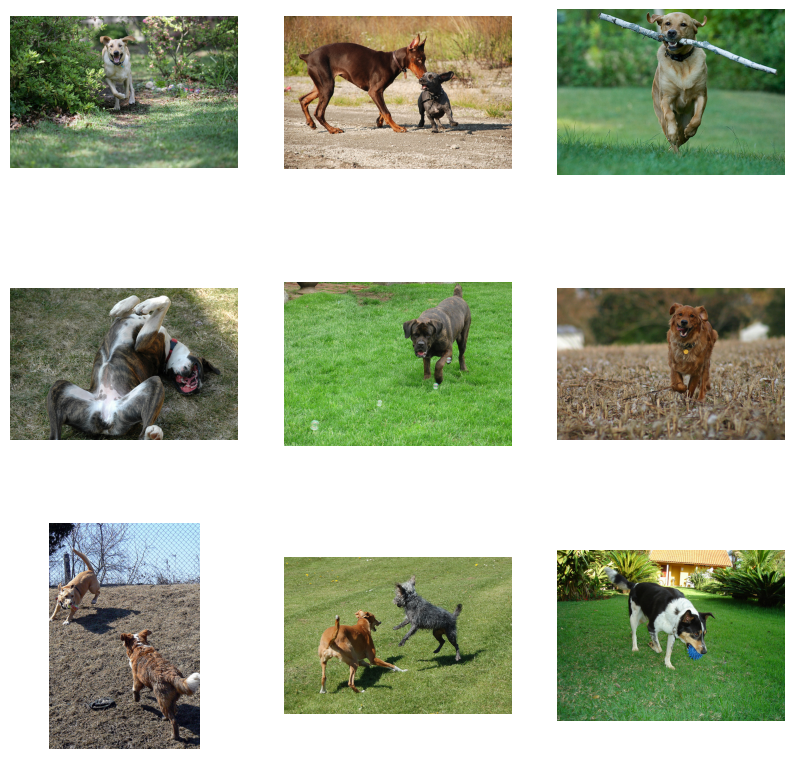

In [14]:
find_matches(
    model,
    image_embeddings,
    query="a dog playing on the grass", # copy this cell and change the path to get images for entered caption
    image_filenames=valid_df["image"].values,
    n=9,
)

/tmp/ipykernel_75263/4176547949.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values).to(Configurations.DEVICE)


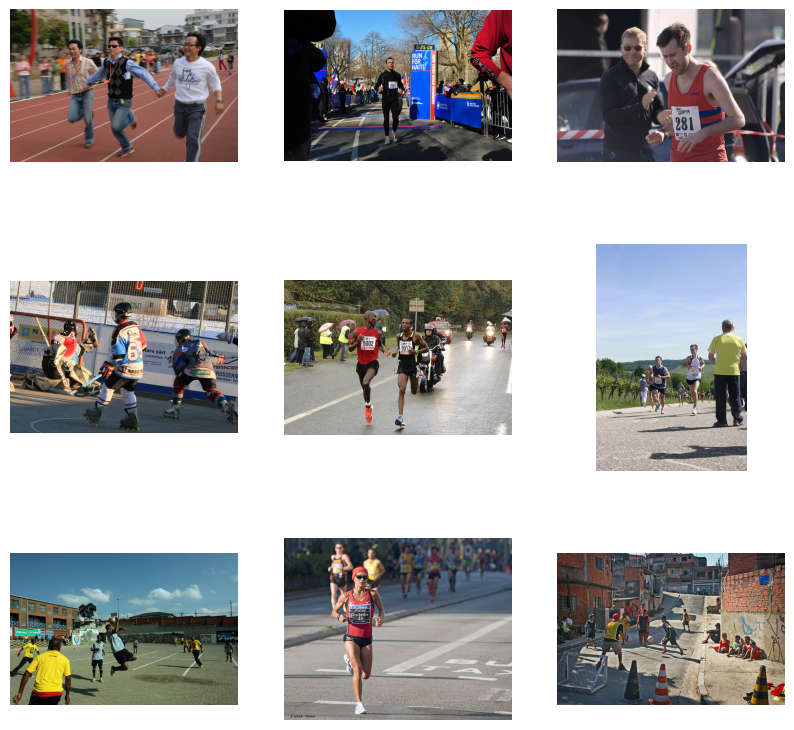

In [15]:
find_matches(
    model,
    image_embeddings,
    query="boys running marathon", # copy this cell and change the path to get images for entered caption
    image_filenames=valid_df["image"].values,
    n=9,
)